# Analysis

Read data files from multiple chillers and create a model

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

import pickle

%matplotlib inline

import re
import glob


# import custome utility functions
from util import plot_curves
from util import get_Xy
from util import compute_lift_lines

## LASSO

In [43]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

0.8514419710277483

In [44]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
#alpha_list = [5e-6, 1e-5, 5e-5, 1e-4,5e-4,1e-3]
alpha_list = [1e-5, 5e-5, 1e-4,5e-4]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y2_test, lr_lasso.predict(X2_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


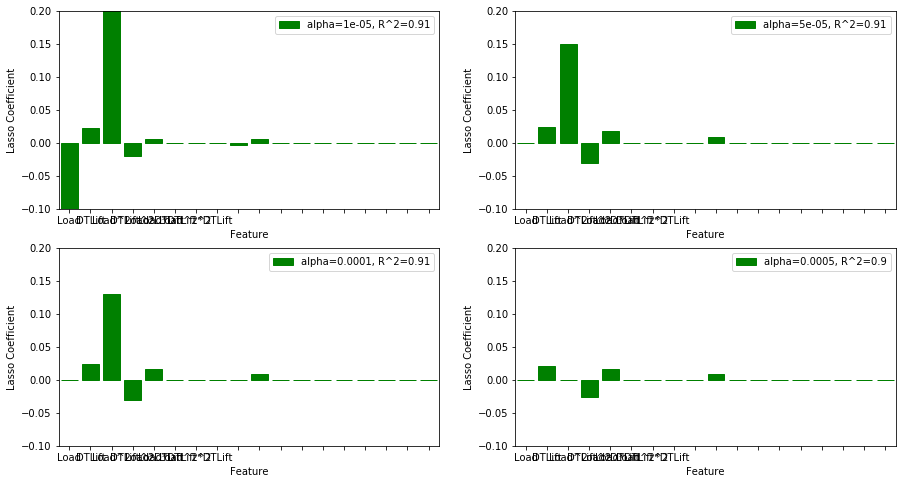

In [59]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             xticklabels=['','Load','DTLift','Load^2','DTLift^2',
                          'Load*DTLift','Load*DTLift^2','Load^2*DTLift'],
             ylim=(-.1,.2),
             xlim=(0.5,num_features+.5))

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [61]:
X_train.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift',
       'CompSH_mean', 'CompSH_std', 'CompSH_median', 'EvapApproach_mean',
       'EvapApproach_std', 'EvapApproach_median', 'CondApproach_mean',
       'CondApproach_std', 'CondApproach_median', 'REFLVL_mean', 'REFLVL_std',
       'REFLVL_median', 'RatedTon'],
      dtype='object')

## Read in all data files and chiller characteristics

In [40]:
PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
PlantToModel.set_index('Plant',inplace=True)
ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')
#ModelCharacteristics.set_index('ModelNo',inplace=True)

In [41]:
PlantToModel.loc['B1']['Model']

'YKKJKLH9-CWF'

In [42]:
ModelCharacteristics.head()

ModelNo  RatedTons  VarSpeed  RatedkW  RatedFLA  CMinFlow  CDesFlow  \
0   YKPFP4K2-FBG       1500         1    831.5    1184.0       NaN      4500   
1   YKKJKLH9-CWF        900         1    506.0       NaN     792.0      2700   
2   YKKCKSH9-CWG        900         1    490.0       NaN    1059.0      2700   
3   YKK5K4K1-DAG       1200         1    782.0    1126.0    1292.0      3600   
4  YKMQMRK1-CYGS        853         0    497.0     880.0    1046.0      2189   

   CMaxFlow  CPDrop  CEnterTemp  CLeaveTemp  EMinFlow  EDesFlow  EMaxFlow  \
0       NaN    19.6          85       94.23       NaN      3600       NaN   
1    3787.0    25.9          85       94.21     791.0      1545    2580.0   
2    4121.0    22.2          85       94.18    1059.0      1545    3424.0   
3    4657.0    27.1          85       94.20     922.0      2889    3687.0   
4    2869.0    13.8          77       87.80     887.0      1896    2710.0   

   EPDrop  EEnterTemp  ELeaveTemp  
0   21.00       53.97        44.0  
1   17.80       58.00        44.0  
2   11.50       58.00        44.0  
3   26.50       52.00        42.0  
4   10.28       41.00        51.8

In [66]:
df_all = pd.DataFrame()

for file in glob.glob('data/*chiller.csv'):
    foo = re.match('data/(\d*[A-Z]+)(\d+)_chiller.csv',file)
    if foo is None:
        raise AttributeError(f'could not match {file}')

    PlantCode = foo.group(1)
    ChCode = foo.group(2)
    
    print(f'opening file: {file}        plant code: {PlantCode}        chiller code: {ChCode}')
    
    df = pd.read_csv(file)
    ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
    df['ModelNo'] = ModelNo
    df['Chiller'] = PlantCode+ChCode
    
    df = pd.merge(df, ModelCharacteristics, on='ModelNo')
    df_all = df_all.append(df)


opening file: data/5T14_chiller.csv        plant code: 5T        chiller code: 14
opening file: data/S3_chiller.csv        plant code: S        chiller code: 3
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
opening file: data/BC1_chiller.csv        plant code: BC        chiller code: 1
opening file: data/5T18_chiller.csv        plant code: 5T        chiller code: 18
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
opening file: data/C2_chiller.csv        plant code: C        chiller code: 2
opening file: data/5T20_chiller.csv        plant code: 5T        chiller code: 20
opening file: data/C1_chiller.csv        plant code: C        chiller code: 1
opening file: data/1T7_chiller.csv      

In [58]:
df_all.shape

(996617, 31)

In [2]:
data_file = 'data/ALL_chillers.csv'

In [59]:
df_all.to_csv(data_file)

In [60]:
ModelCharacteristics.columns

Index(['ModelNo', 'RatedTons', 'VarSpeed', 'RatedkW', 'RatedFLA', 'CMinFlow',
       'CDesFlow', 'CMaxFlow', 'CPDrop', 'CEnterTemp', 'CLeaveTemp',
       'EMinFlow', 'EDesFlow', 'EMaxFlow', 'EPDrop', 'EEnterTemp',
       'ELeaveTemp'],
      dtype='object')

In [8]:
def new_get_Xy(file_name,features=[]):
    def clean_NaN(df):
        df.dropna(subset=['Load','DTLift','kW/Ton'],inplace=True)
        return df

    df = pd.read_csv(file_name)

    if 'ModelNo' not in df.columns:
        print('getting model info')
        
        foo = re.match('data/(\d*[A-Z]+)(\d+)_chiller.csv',file_name)
        if foo is None:
            raise AttributeError(f'could not match {file_name}')

        PlantCode = foo.group(1)
        ChCode = foo.group(2)

        print(f'opening file: {file_name}        plant code: {PlantCode}        chiller code: {ChCode}')

        PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
        PlantToModel.set_index('Plant',inplace=True)
        ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')

        ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
        df['ModelNo'] = ModelNo
        df['Chiller'] = PlantCode+ChCode

        df = pd.merge(df, ModelCharacteristics, on='ModelNo')    

    num_rows = df.shape[0]
    df = clean_NaN(df)
    print('DataFrame rows with NaN removed: ',num_rows - df.shape[0])

    y = df['kW/Ton']
    X = df[['Load','DTLift']]

    if 'HigherOrder' in features:
        X['Load^2']        = df['Load']**2
        X['Load*DTLift']   = df['Load']*df['DTLift']
        X['Load^2*DTLift'] = (df['Load']**2)*df['DTLift']
    if 'ModelInfo' in features:    
        X['RatedTons']  = df['RatedTons']
        X['RatedkW']    = df['RatedkW']
        X['CDesFlow']   = df['CDesFlow']
        X['CPDrop']     = df['CPDrop']
        X['CEnterTemp'] = df['CEnterTemp']
        X['CLeaveTemp'] = df['CLeaveTemp']
        X['EDesFlow']   = df['EDesFlow']
        X['EPDrop']     = df['EPDrop']
        X['EEnterTemp'] = df['EEnterTemp']
        X['ELeaveTemp'] = df['ELeaveTemp']

    return X, y, df


In [26]:
data_file = 'data/ALL_chillers.csv'
feat = ['HigherOrder','ModelInfo']

X, y, df = new_get_Xy(data_file,feat)

print(X.shape)
print(X.dropna().shape)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

DataFrame rows with NaN removed:  54485


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

(942132, 15)
(942132, 15)
(565279, 15) (565279,)
(376853, 15) (376853,)


In [27]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

6.495721888224664
[-4.15301300e-01  2.26546070e-02  5.32403773e-01 -2.14191572e-02
  5.21034489e-03 -1.32921367e-02  4.30764549e-03  3.92625173e-03
 -2.05180913e-02 -6.78817905e-02 -7.51449343e-02 -2.85607655e-04
  2.63606825e-03  3.14792910e-02  1.08337643e-01]


In [28]:
print('train: ',lr.score(X_train,y_train))
print('test : ',lr.score(X_test,y_test))

train:  0.9075376015235922
test :  0.908050362358404


In [46]:
def Ch_Results(Chiller,feat,RatedTon,lr):

    data_file = 'data/'+Chiller+'_chiller.csv'
    X_test, y_test, df = new_get_Xy(data_file,feat)
    print(Chiller+':',X_train.shape,y_train.shape)
    print('R^2: ',lr.score(X1_test,y1_test))
    
    lift_lines = compute_lift_lines(lr, feat, df, RatedTon, plot=False)
    plot_curves(df,lift_lines,'Chiller '+Chiller)



## BCBS

getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  148


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

B1: (565279, 15) (565279,)
R^2:  0.9049464228034325


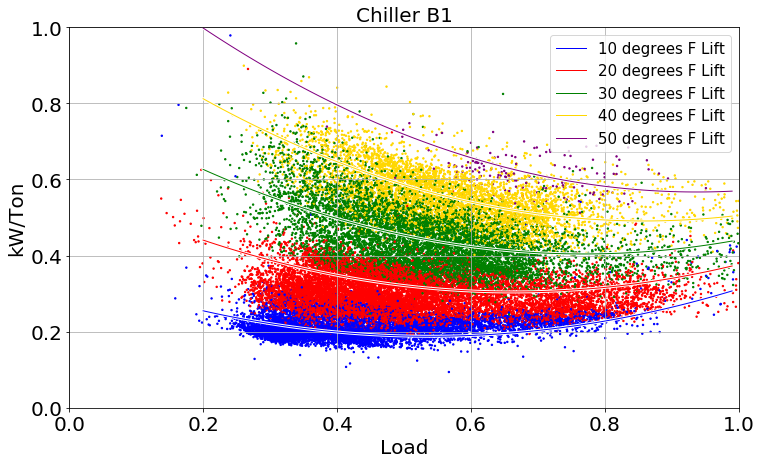

getting model info
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
DataFrame rows with NaN removed:  200


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

B2: (565279, 15) (565279,)
R^2:  0.9049464228034325


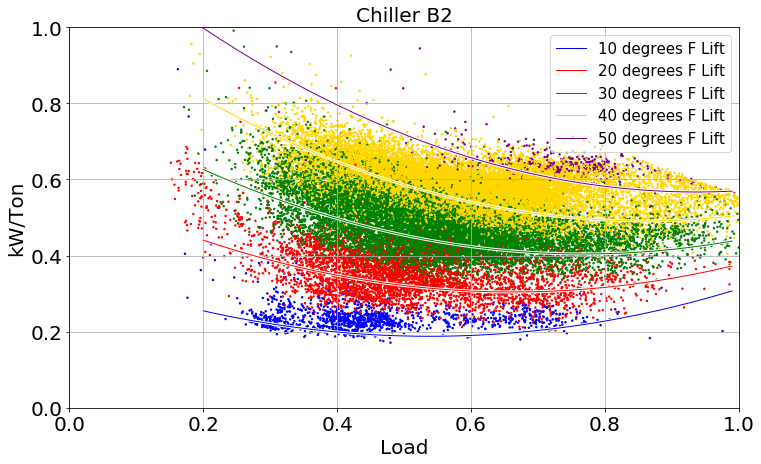

getting model info
opening file: data/B3_chiller.csv        plant code: B        chiller code: 3
DataFrame rows with NaN removed:  101


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

B3: (565279, 15) (565279,)
R^2:  0.9049464228034325


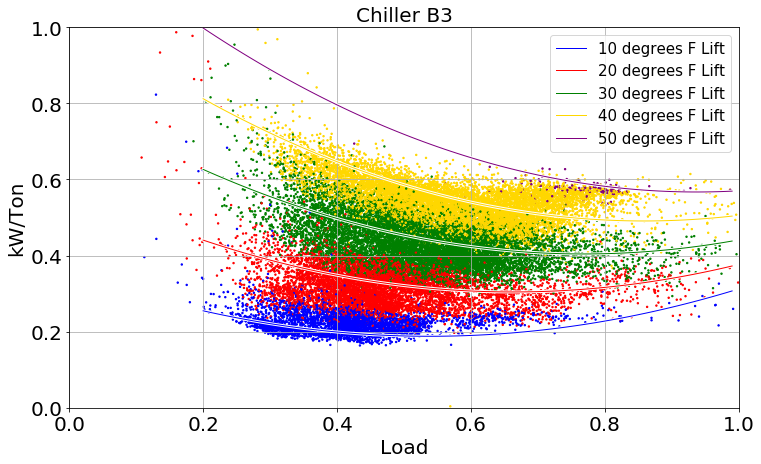

getting model info
opening file: data/B4_chiller.csv        plant code: B        chiller code: 4
DataFrame rows with NaN removed:  2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

B4: (565279, 15) (565279,)
R^2:  0.9049464228034325


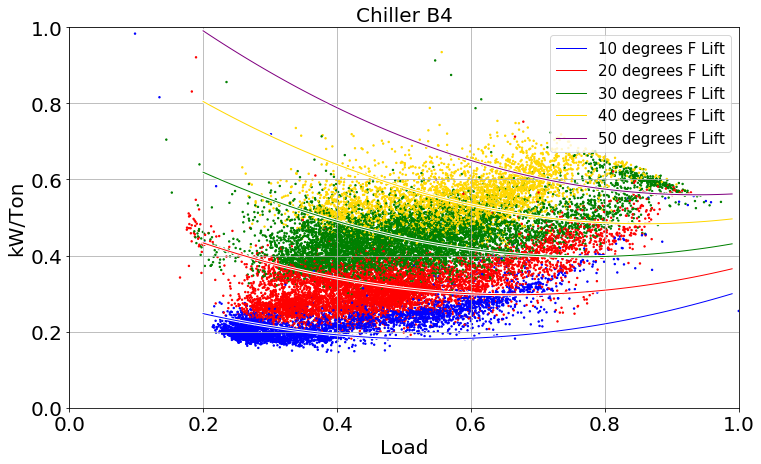

In [45]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 900
    
PlantCode = 'B'
Chillers = ['1','2','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,RatedTon,lr)


## Tabreed BD01

getting model info
opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
DataFrame rows with NaN removed:  3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T1: (565279, 15) (565279,)
R^2:  0.9049464228034325


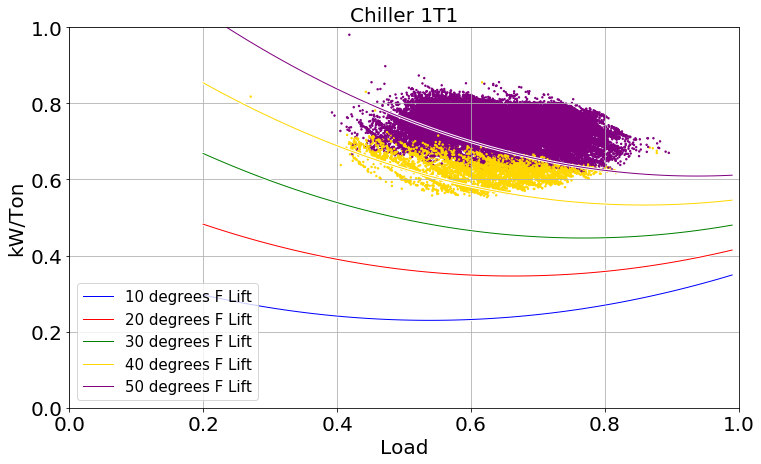

getting model info
opening file: data/1T3_chiller.csv        plant code: 1T        chiller code: 3
DataFrame rows with NaN removed:  0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T3: (565279, 15) (565279,)
R^2:  0.9049464228034325


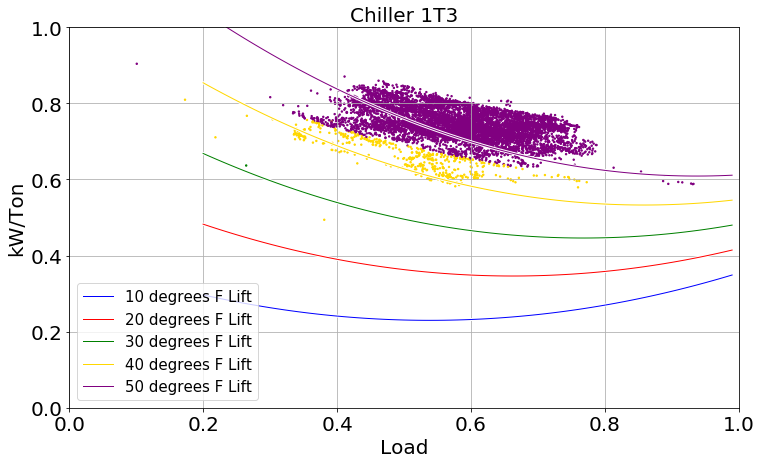

getting model info
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
DataFrame rows with NaN removed:  0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T4: (565279, 15) (565279,)
R^2:  0.9049464228034325


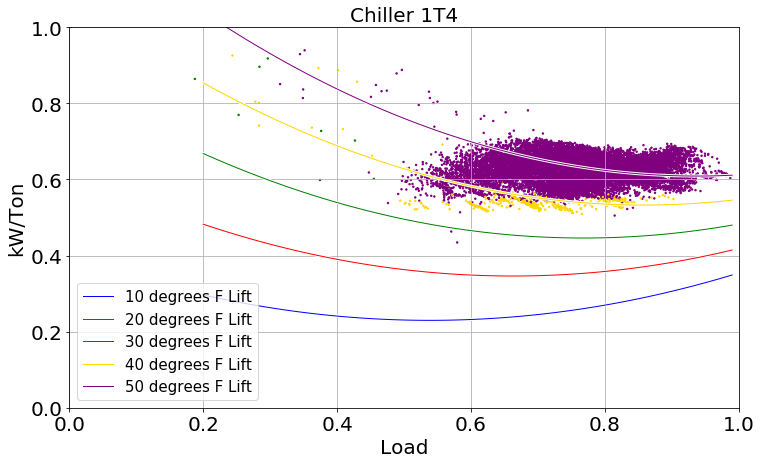

getting model info
opening file: data/1T5_chiller.csv        plant code: 1T        chiller code: 5
DataFrame rows with NaN removed:  3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T5: (565279, 15) (565279,)
R^2:  0.9049464228034325


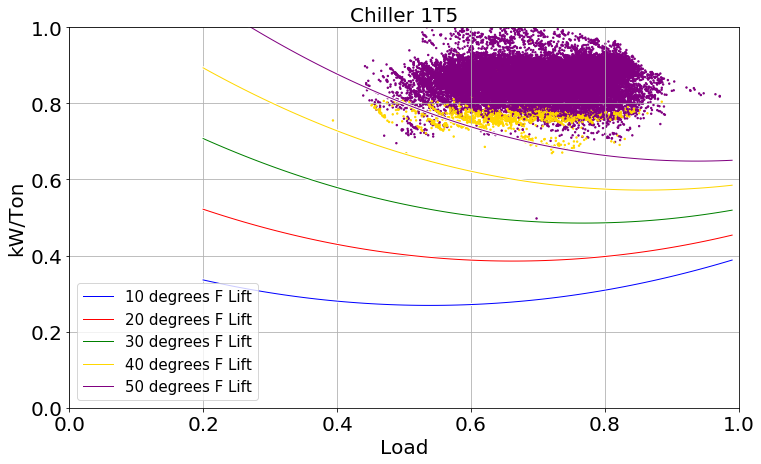

getting model info
opening file: data/1T6_chiller.csv        plant code: 1T        chiller code: 6
DataFrame rows with NaN removed:  17929


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T6: (565279, 15) (565279,)
R^2:  0.9049464228034325


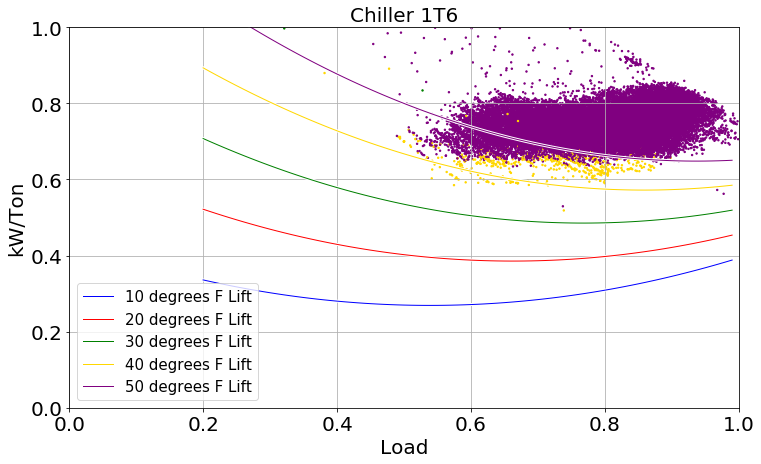

getting model info
opening file: data/1T7_chiller.csv        plant code: 1T        chiller code: 7
DataFrame rows with NaN removed:  58


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T7: (565279, 15) (565279,)
R^2:  0.9049464228034325


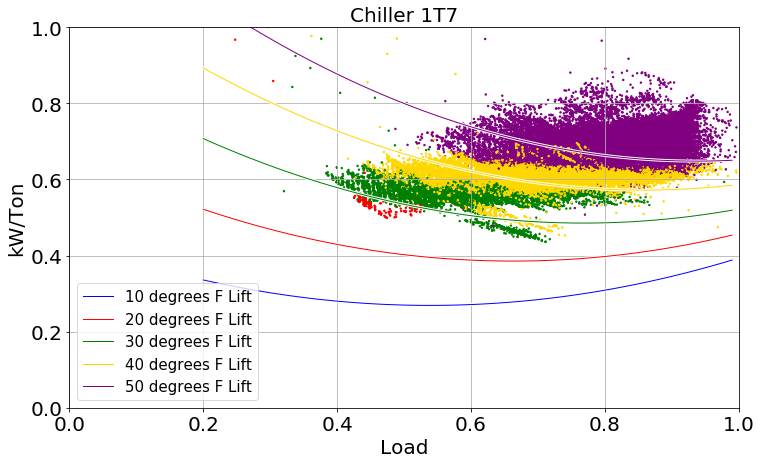

getting model info
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
DataFrame rows with NaN removed:  39


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T8: (565279, 15) (565279,)
R^2:  0.9049464228034325


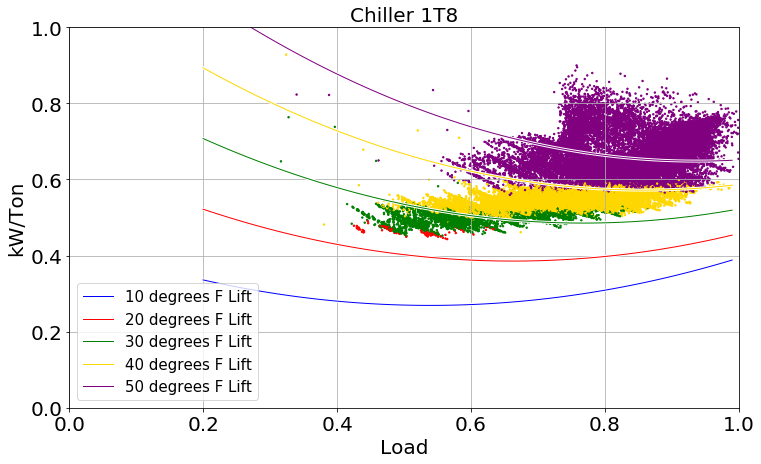

getting model info
opening file: data/1T9_chiller.csv        plant code: 1T        chiller code: 9
DataFrame rows with NaN removed:  20


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T9: (565279, 15) (565279,)
R^2:  0.9049464228034325


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


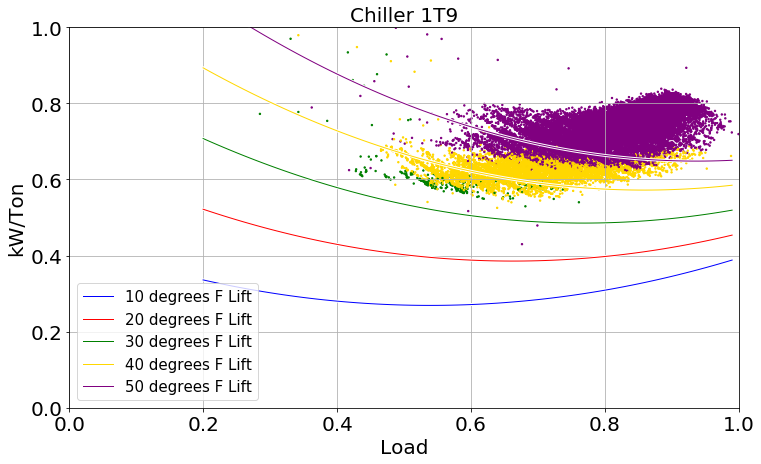

getting model info
opening file: data/1T10_chiller.csv        plant code: 1T        chiller code: 10
DataFrame rows with NaN removed:  7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T10: (565279, 15) (565279,)
R^2:  0.9049464228034325


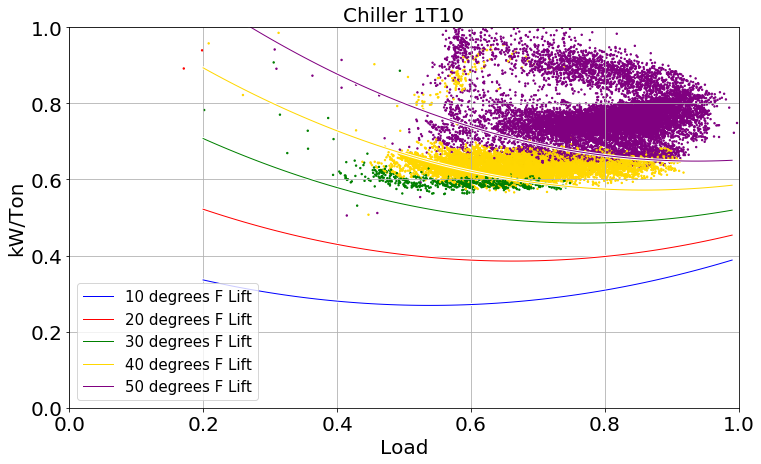

getting model info
opening file: data/1T11_chiller.csv        plant code: 1T        chiller code: 11
DataFrame rows with NaN removed:  23


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T11: (565279, 15) (565279,)
R^2:  0.9049464228034325


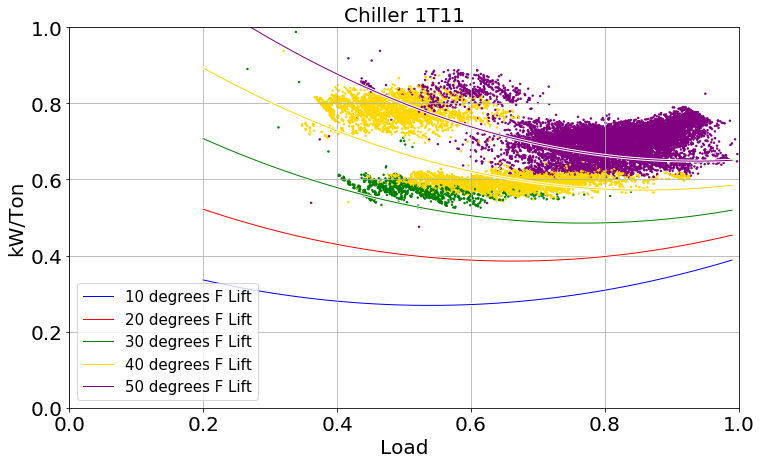

getting model info
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
DataFrame rows with NaN removed:  30


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

1T12: (565279, 15) (565279,)
R^2:  0.9049464228034325


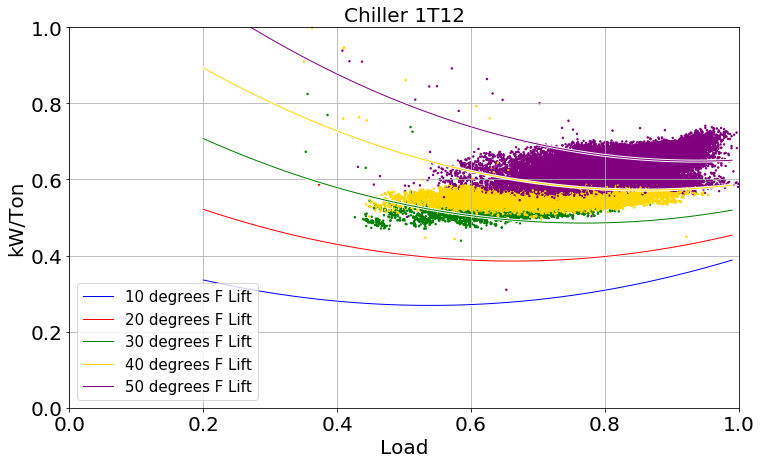

In [49]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 1850
    
PlantCode = '1T'
Chillers = ['1','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,RatedTon,lr)

RatedTon = 1850
PlantCode = '1T'
Chillers = ['5','6','7','8','9','10','11','12']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,RatedTon,lr)


## Samford

In [65]:
feat = ['AddOther','HigherOrder']
#feat = ['HigherOrder']

RatedTon = 1500

data_file = 'data/S1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,RatedTon,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/S2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,RatedTon,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/S3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,RatedTon,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/S4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,RatedTon,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame rows with NaN removed:  3


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

CH1: (14272, 18) (14272,)
DataFrame rows with NaN removed:  16
CH2: (5459, 18) (5459,)
DataFrame rows with NaN removed:  7
CH3: (3835, 18) (3835,)
DataFrame rows with NaN removed:  8
CH4: (13705, 18) (13705,)


In [66]:
X_tot = pd.concat([X_train,X2_test,X3_test,X4_test])
y_tot = pd.concat([y_train,y2_test,y3_test,y4_test])

print(X_tot.shape)
X_tot.dropna().shape

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(37271, 18)
(22362, 18) (22362,)


In [67]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

0.25362060449484036
[-8.97450731e-01  8.49828523e-03  8.91471045e-01  1.31478874e-02
 -1.52863772e-02 -1.06935816e-03 -2.53127574e-04 -1.69054816e-03
  1.04292057e-03 -1.00678613e-03  3.35036797e-04  1.83485570e-04
 -6.69151593e-05  1.07022607e-04  4.35905151e-05  2.23692353e-03
  5.56606181e-05  0.00000000e+00]


In [68]:
print('train with S1:',lr.score(X_train,y_train))
print('test with S2: ',lr.score(X2_test,y2_test))
print('test with S3: ',lr.score(X3_test,y3_test))
print('test with S4: ',lr.score(X4_test,y4_test))

train with S1: 0.9812101907634712
test with S2:  0.9861083375228581
test with S3:  0.9647309141888166
test with S4:  0.9846449375011255


In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

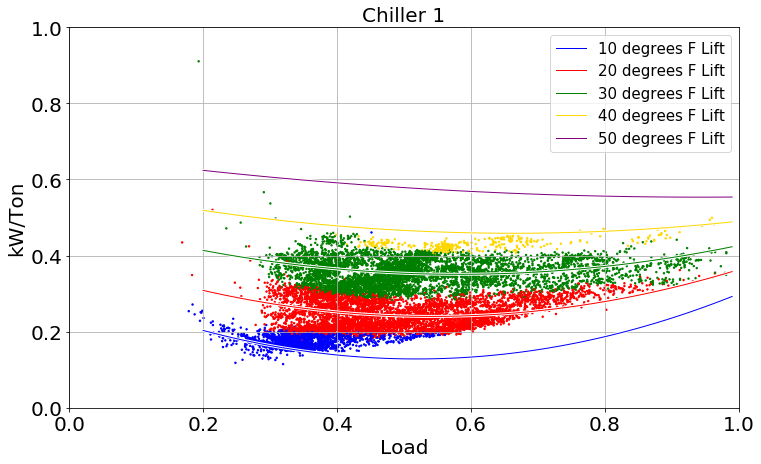

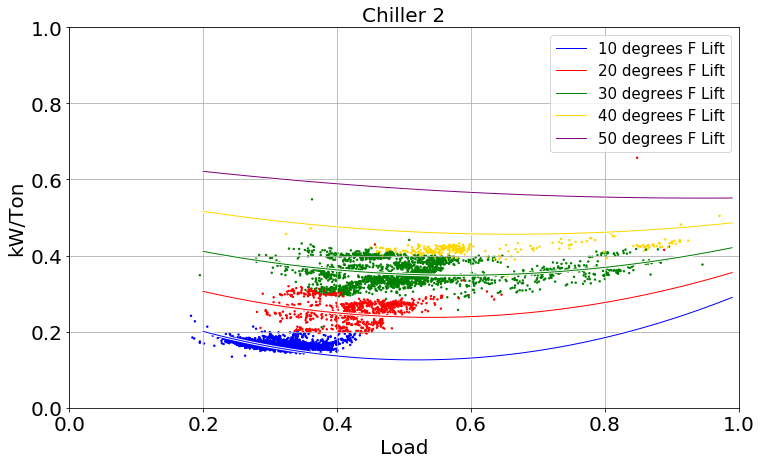

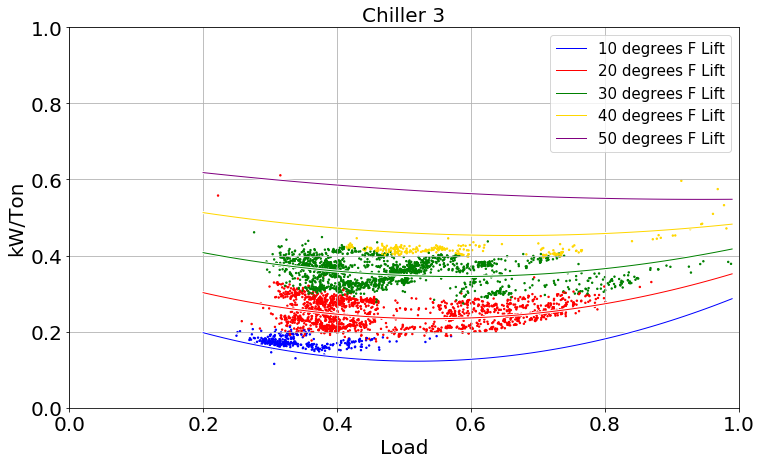

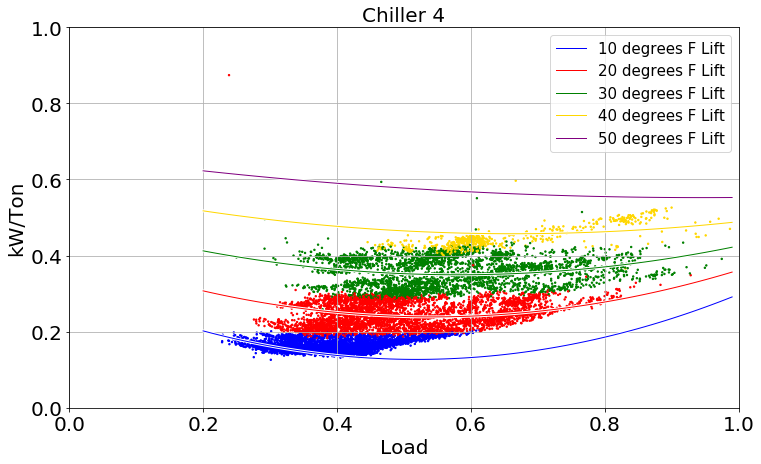

In [69]:
lift_lines = compute_lift_lines(lr, feat, df1, RatedTon, plot=False)
plot_curves(df1,lift_lines,'Chiller 1')

lift_lines = compute_lift_lines(lr, feat, df2, RatedTon, plot=False)
plot_curves(df2,lift_lines,'Chiller 2')

lift_lines = compute_lift_lines(lr, feat, df3, RatedTon, plot=False)
plot_curves(df3,lift_lines,'Chiller 3')

lift_lines = compute_lift_lines(lr, feat, df4, RatedTon, plot=False)
plot_curves(df4,lift_lines,'Chiller 4')

In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

## BCBS

CH1 YKKJKLH9-CWF 900 Tons   
CH2 YKKJKLH9-CWF 900 Tons   
CH3 YKKJKLH9-CWF 900 Tons   
CH4 YKKCKSH9-CWG 900 Tons   

In [62]:
feat = ['AddOther','HigherOrder']
#feat = ['HigherOrder']

RateTon = 900

data_file = 'data/B1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,RatedTon,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/B2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,RatedTon,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/B3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,RatedTon,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/B4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,RatedTon,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame rows with NaN removed:  149


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

CH1: (33575, 18) (33575,)
DataFrame rows with NaN removed:  200
CH2: (36143, 18) (36143,)
DataFrame rows with NaN removed:  101
CH3: (29786, 18) (29786,)
DataFrame rows with NaN removed:  2
CH4: (23288, 18) (23288,)


In [63]:
X_tot = pd.concat([X_train,X2_test,X3_test,X4_test])
y_tot = pd.concat([y_train,y2_test,y3_test,y4_test])

print(X_tot.shape)
X_tot.dropna().shape

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(122792, 18)
(73675, 18) (73675,)


model coefficients: -65997130059.77594 [-6.89675357e-01  1.93263577e-02  8.10778377e-01 -9.63561174e-03
 -3.30995641e-03  4.43827333e+09 -1.32619917e+09  3.12989447e+09
  2.57727017e+09  2.21654712e+09  3.94530493e+09  1.54530054e+09
  3.34674724e+08  1.23228380e+09  1.42338628e+10  3.13459129e+09
 -1.58088379e+10  0.00000000e+00] 

train with B1: 0.9079661439025166
test with B2:  0.8824960222226547
test with B3:  0.9271641132374691
test with B4:  0.7823242456134122


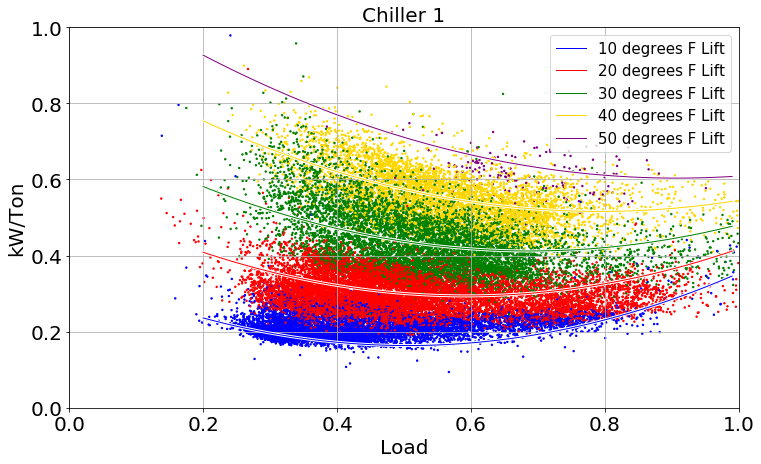

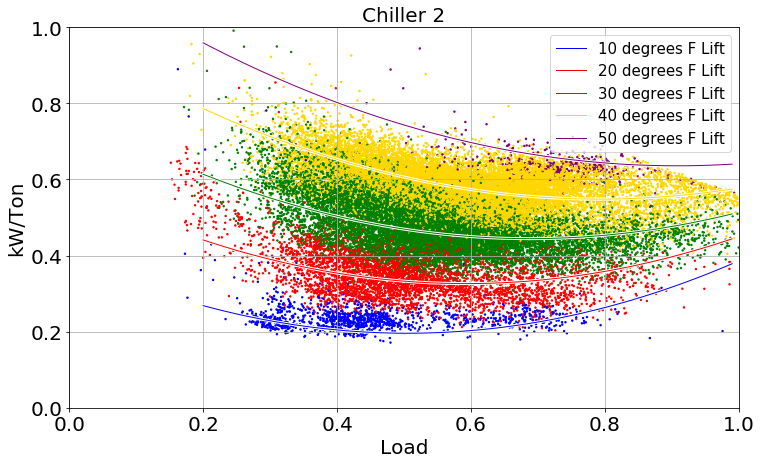

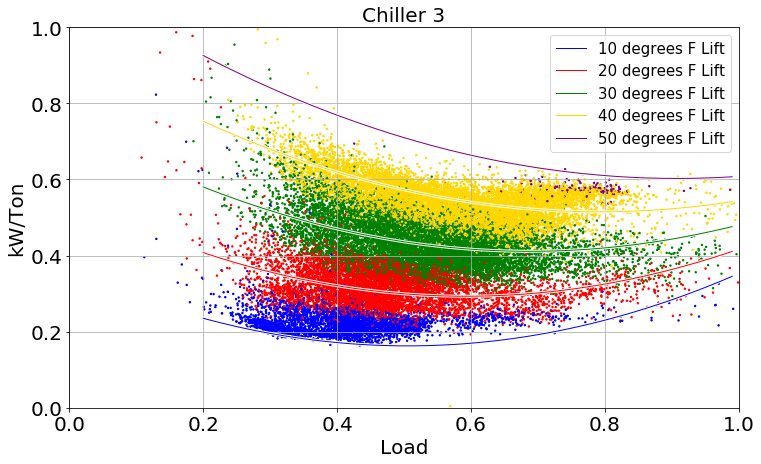

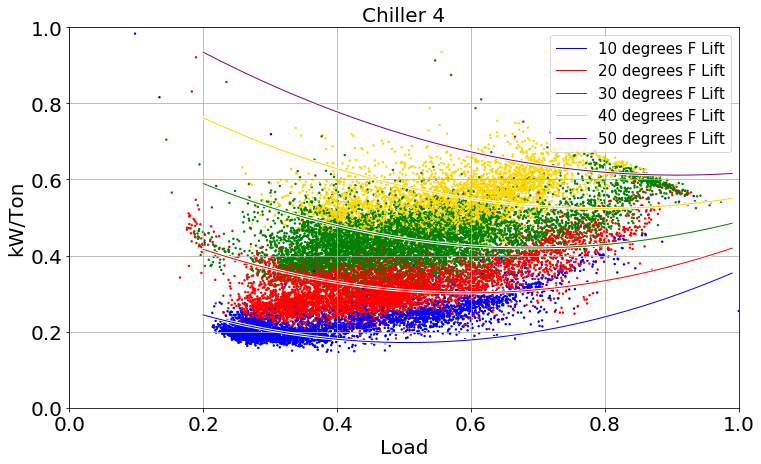

In [64]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print('model coefficients:',lr.intercept_, lr.coef_,'\n')

print('train with B1:',lr.score(X_train,y_train))
print('test with B2: ',lr.score(X2_test,y2_test))
print('test with B3: ',lr.score(X3_test,y3_test))
print('test with B4: ',lr.score(X4_test,y4_test))

lift_lines = compute_lift_lines(lr, feat, df1, RatedTon, plot=False)
plot_curves(df1,lift_lines,'Chiller 1')

lift_lines = compute_lift_lines(lr, feat, df2, RatedTon, plot=False)
plot_curves(df2,lift_lines,'Chiller 2')

lift_lines = compute_lift_lines(lr, feat, df3, RatedTon, plot=False)
plot_curves(df3,lift_lines,'Chiller 3')

lift_lines = compute_lift_lines(lr, feat, df4, RatedTon, plot=False)
plot_curves(df4,lift_lines,'Chiller 4')

## CMH

In [2]:
feat = ['AddOther','HigherOrder']
#feat = ['HigherOrder']

RatedTon = 1200

data_file = 'data/C1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,RatedTon,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/C2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,RatedTon,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/C3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,RatedTon,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/C4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,RatedTon,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame rows with NaN removed:  1450


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

CH1: (34965, 18) (34965,)
DataFrame rows with NaN removed:  9879
CH2: (25166, 18) (25166,)
DataFrame rows with NaN removed:  5067
CH3: (41276, 18) (41276,)
DataFrame rows with NaN removed:  2128
CH4: (43362, 18) (43362,)


In [3]:
X_tot = pd.concat([X_train,X2_test,X3_test,X4_test])
y_tot = pd.concat([y_train,y2_test,y3_test,y4_test])

print(X_tot.shape)
X_tot.dropna().shape

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(144769, 18)
(86861, 18) (86861,)


0.8382294341707355
[-5.19267024e-01  1.27755472e-02  5.28992920e-01 -5.75570426e-03
 -5.41384682e-04  3.46180956e-04 -1.10416776e-02 -2.25215534e-02
 -1.87180110e-02  3.41472414e-03 -1.81216442e-02  1.16415192e-02
 -1.74847761e-02 -3.37152656e-03  3.22264273e-02 -5.81054491e-02
 -3.09991624e-02  0.00000000e+00]
train with C1: 0.9521602685502688
test with C2:  0.9067486110704069
test with C3:  0.9448655224091086
test with C4:  0.9552304891331744


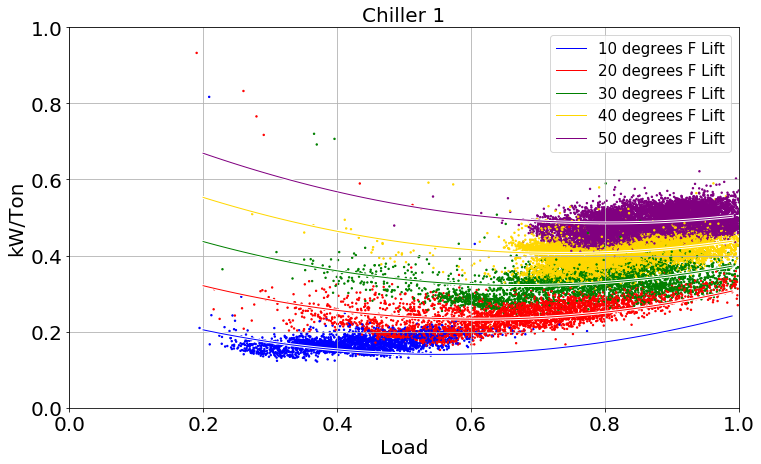

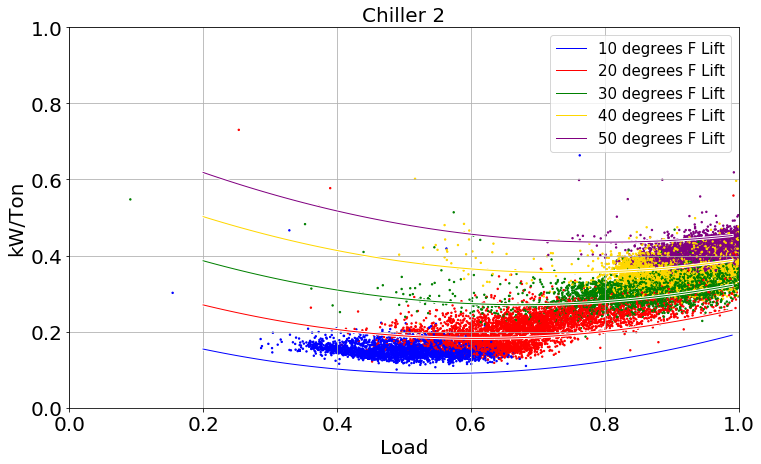

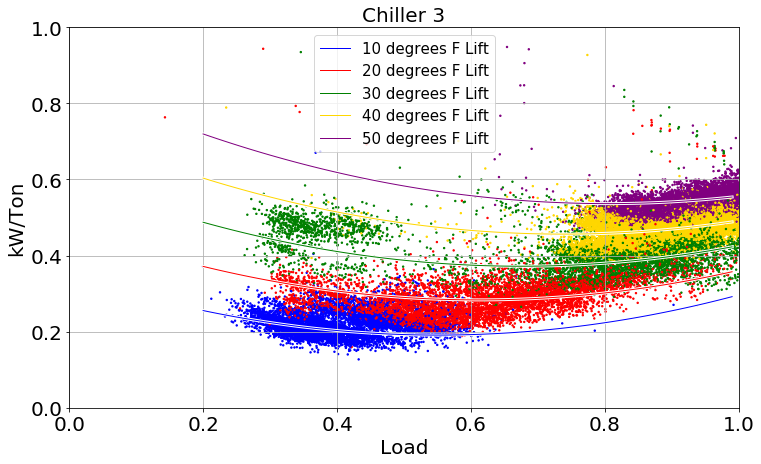

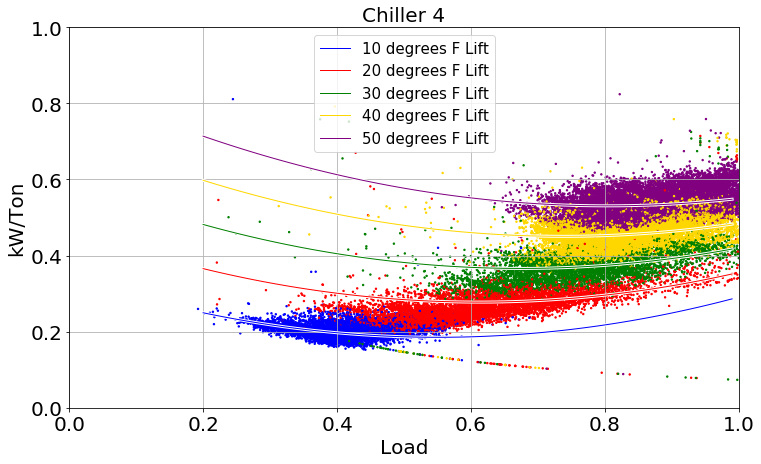

In [4]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

print('train with C1:',lr.score(X_train,y_train))
print('test with C2: ',lr.score(X2_test,y2_test))
print('test with C3: ',lr.score(X3_test,y3_test))
print('test with C4: ',lr.score(X4_test,y4_test))

lift_lines = compute_lift_lines(lr, feat, df1, RatedTon, plot=False)
plot_curves(df1,lift_lines,'Chiller 1')

lift_lines = compute_lift_lines(lr, feat, df2, RatedTon, plot=False)
plot_curves(df2,lift_lines,'Chiller 2')

lift_lines = compute_lift_lines(lr, feat, df3, RatedTon, plot=False)
plot_curves(df3,lift_lines,'Chiller 3')

lift_lines = compute_lift_lines(lr, feat, df4, RatedTon, plot=False)
plot_curves(df4,lift_lines,'Chiller 4')

## Tabreed DB05

getting model info
opening file: data/5T14_chiller.csv        plant code: 5T        chiller code: 14
DataFrame rows with NaN removed:  1058


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

5T14: (565279, 15) (565279,)
R^2:  0.9049464228034325


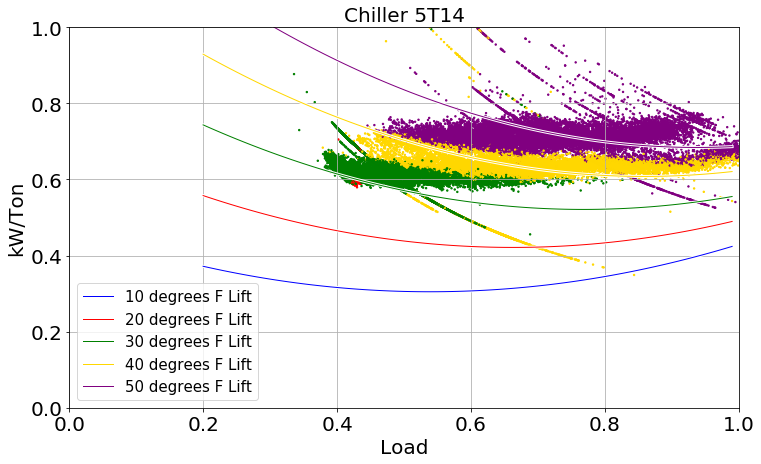

getting model info
opening file: data/5T16_chiller.csv        plant code: 5T        chiller code: 16
DataFrame rows with NaN removed:  235


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

5T16: (565279, 15) (565279,)
R^2:  0.9049464228034325


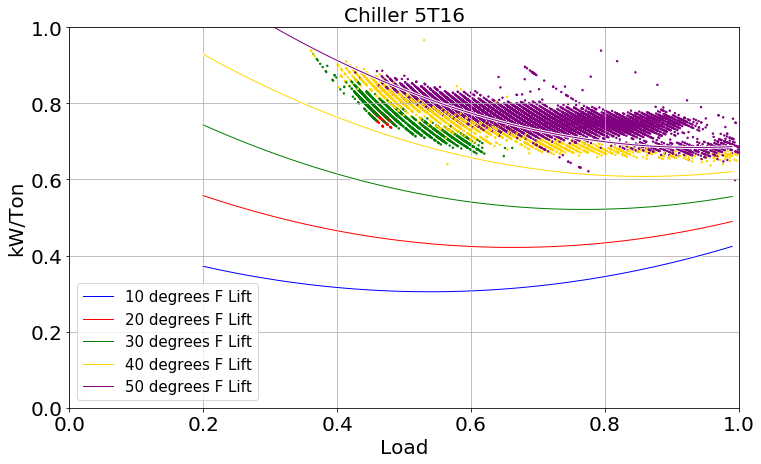

getting model info
opening file: data/5T18_chiller.csv        plant code: 5T        chiller code: 18
DataFrame rows with NaN removed:  639


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

5T18: (565279, 15) (565279,)
R^2:  0.9049464228034325


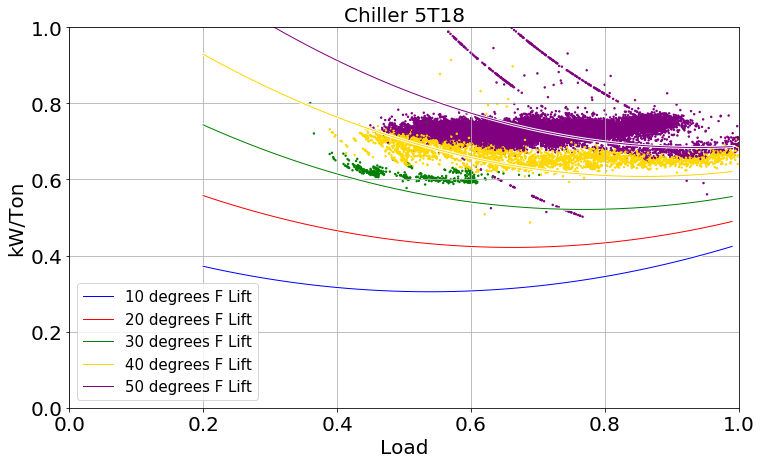

getting model info
opening file: data/5T20_chiller.csv        plant code: 5T        chiller code: 20
DataFrame rows with NaN removed:  189


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

5T20: (565279, 15) (565279,)
R^2:  0.9049464228034325


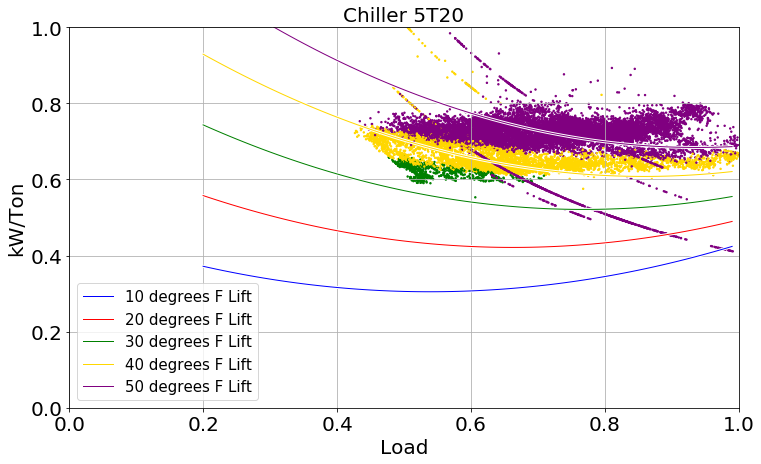

In [50]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 1875
    
PlantCode = '5T'
Chillers = ['14','16','18','20']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,RatedTon,lr)


## Bio Cork

getting model info
opening file: data/BC1_chiller.csv        plant code: BC        chiller code: 1
DataFrame rows with NaN removed:  5765


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

BC1: (565279, 15) (565279,)
R^2:  0.9049464228034325


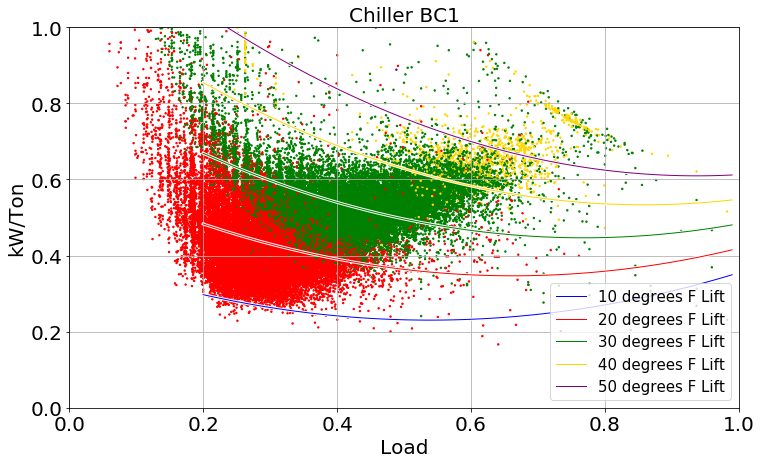

getting model info
opening file: data/BC2_chiller.csv        plant code: BC        chiller code: 2
DataFrame rows with NaN removed:  9491


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

BC2: (565279, 15) (565279,)
R^2:  0.9049464228034325


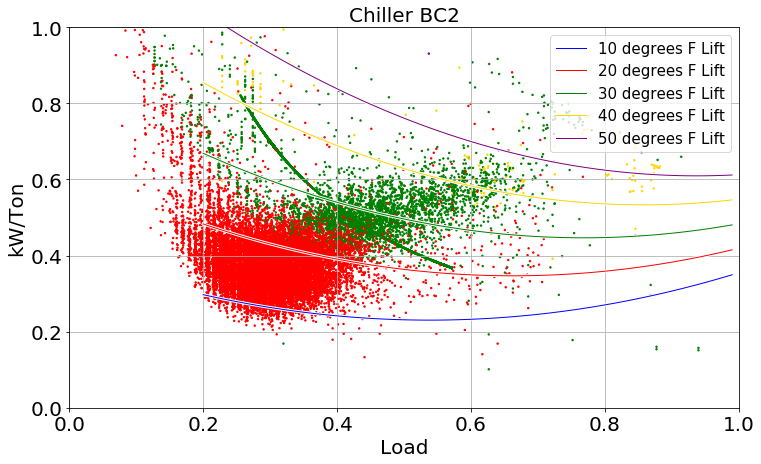

In [51]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 853
    
PlantCode = 'BC'
Chillers = ['1','2']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,RatedTon,lr)


## Things to try

Random Forest Regression